In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

### Загрузка временного ряда

In [2]:
pjme_df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
pjme_df.sort_index(inplace=True)
pjme_df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


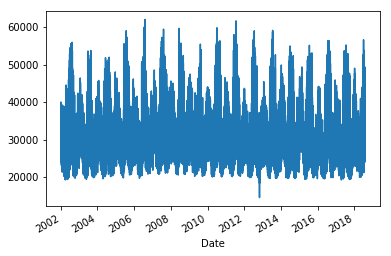

In [3]:
pjme_time = pjme_df['PJME_MW']

pjme_time.plot()
plt.show()

### Экспоненциальное сглаживание

In [4]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

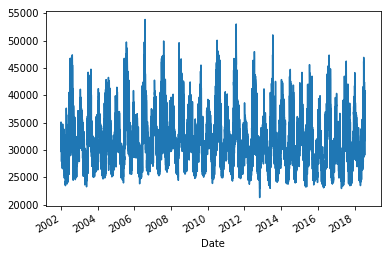

In [5]:
df = pd.DataFrame({'0': exponential_smoothing(pjme_time, 0.05)},
                  index=pjme_time.index)

df['0'].plot()
plt.show()

### Создание признаков (истории) временного ряда

In [6]:
for i in range(1, 11):
    df[str(i)] = df['0'].shift(i)
df.fillna(0, inplace=True)

df.head()

,0,1,2,3,4,5,6,7,8,9,10
Date,,,,,,,,,,,
2002-01-01,30393.00000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-01-01,30336.60000,30393.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-01-01,30237.62000,30336.600,30393.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-01-01,30120.68900,30237.620,30336.60,30393.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-01-01,30017.50455,30120.689,30237.62,30336.6,30393.0,0.0,0.0,0.0,0.0,0.0,0.0


### Разделение ряда на train и test

In [7]:
def split_data_b(df, split_date):
    return df.loc[df.index.get_level_values(df.index.name) <= split_date].copy(), \
           df.loc[df.index.get_level_values(df.index.name) >  split_date].copy()

In [8]:
train_df, test_df = split_data_b(df, split_date='2016-01-01')

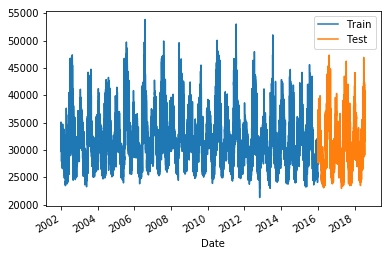

In [9]:
train_df['0'].plot(label='Train')
test_df['0'].plot(label='Test')
plt.legend(loc='best')
plt.show()

In [10]:
X_train = train_df.iloc[:, 1:] # отсчеты с 1-го по 10-й
X_test = test_df.iloc[:, 1:]
y_train = train_df['0'] # исходный ряд
y_test = test_df['0']

### MAPE и GradientBoostingRegressor

In [11]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
model_gb = GradientBoostingRegressor(max_depth=6, random_state=0, n_estimators=15)

### Глубина истории - 10 шагов:

In [13]:
model_gb.fit(X_train[11:], y_train[11:]) # без нулей в начале
y_pred = model_gb.predict(X_test)

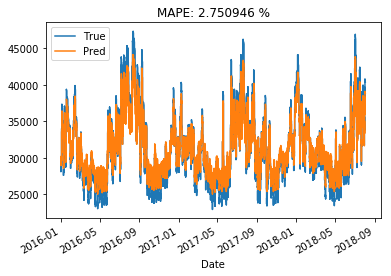

In [14]:
mape_score = round(mean_absolute_percentage_error(y_test, y_pred), 6)

y_test.plot(label='True')
plt.plot(y_test.index, y_pred, label='Pred')
plt.title('MAPE: {} %'.format(mape_score))
plt.legend(loc='best')
plt.show()

### Глубина истории - 1 шаг:

In [15]:
model_gb.fit(X_train[['1']][1:], y_train[1:]) # без нулей в начале
y_pred = model_gb.predict(X_test[['1']])

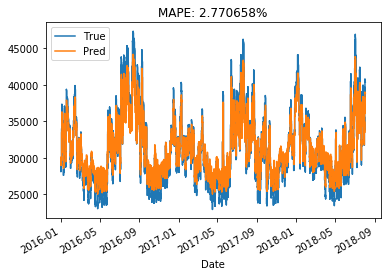

In [16]:
mape_score = round(mean_absolute_percentage_error(y_test, y_pred), 6)

y_test.plot(label='True')
plt.plot(y_test.index, y_pred, label='Pred')
plt.title('MAPE: {}%'.format(mape_score))
plt.legend(loc='best')
plt.show()

- Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

- Оцените ошибку модели из п.1 .

- Сделайте вывод о том, как изменилась ошибка модели по значениям h.

**Вывод по ошибке**: по обоим вариантам глубины удалось достичь практически одинакового значения метрики MAPE (2.7%). Разная рандомизация модели бустинга (через random_state) каждый раз давала разный ответ, который из вариантов лучше, поэтому однозначного предпочтения какой-либо модели пока отдавать не следует.